In [1]:
import openmc
import th_backend

# The OpenMC C-API

In [7]:
R = 0.97 / 2.0           # outer radius of the pincell (cm)
Rf = 0.825 / 2.0         # outer radius of the pellet (cm)
pitch = 1.28             # pitch between pincells (cm)
height = 381.0           # height of the pincell (cm)

power = 60.0e3           # total power produced by pincell (W)
T_inlet = 573.0          # inlet water temperature (K)

In [8]:
N = 10                    # number of coupling layers
H = height / N            # height of each coupling layer

## Materials

In [9]:
# To save us some typing, we will create all the duplicated coolant materials
# in a loop, so first make a list to which we can append all of our materials
all_materials = []

# Then, add the materials for UO2 and zircaloy
uo2 = openmc.Material(name = 'UO2')
uo2.set_density('g/cm3', 10.29769)
uo2.add_element('U', 1.0, enrichment = 2.5)
uo2.add_element('O', 2.0)
all_materials.append(uo2)

zircaloy = openmc.Material(material_id=3, name='Zircaloy 4')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_element('Sn', 0.014, 'wo')
zircaloy.add_element('Fe', 0.00165, 'wo')
zircaloy.add_element('Cr', 0.001, 'wo')
zircaloy.add_element('Zr', 0.98335, 'wo')
all_materials.append(zircaloy)

In [10]:
water_materials = []

for i in range(N):
    water = openmc.Material(name = 'water{:n}'.format(i))
    water.set_density('g/cm3', th_backend.water_density(T_inlet))
    water.add_element('H', 2.0)
    water.add_element('O', 1.0)
    water.add_s_alpha_beta('c_H_in_H2O')

    water_materials.append(water)
    all_materials.append(water)

In [11]:
materials = openmc.Materials(all_materials)
materials.export_to_xml()

## Geometry

In [13]:
pincell_surface = openmc.ZCylinder(r = R)
pellet_surface = openmc.ZCylinder(r = Rf)
rectangular_prism = openmc.model.RectangularPrism(width = pitch, height = pitch, boundary_type = 'reflective')

import numpy as np
planes = [openmc.ZPlane(z0=z) for z in np.linspace(0.0, height, N + 1)]

In [14]:
planes[0].boundary_type = 'vacuum'
planes[-1].boundary_type = 'vacuum'

In [16]:
fuel_cells = []
clad_cells = []
water_cells = []

for i in range(N):
    # these are the two planes that bound the current layer on top and bottom
    layer = +planes[i] & -planes[i + 1]

    fuel_cells.append(openmc.Cell(fill = uo2, region = -pellet_surface & layer, name = 'Fuel{:n}'.format(i)))

    clad_cells.append(openmc.Cell(fill = zircaloy, region = +pellet_surface & -pincell_surface & layer, name = 'Clad{:n}'.format(i)))

    # we need to get the correct water material that belongs to this layer
    water_material = water_materials[i]
    water_cells.append(openmc.Cell(fill = water_material, region = +pincell_surface & layer & -rectangular_prism, name = 'Water{:n}'.format(i)))

In [17]:
root = openmc.Universe(cells = fuel_cells + clad_cells + water_cells)

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

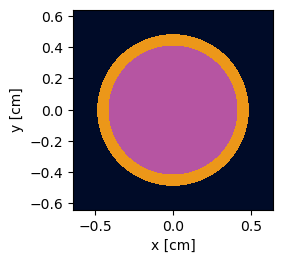

In [18]:
root.plot(width=(pitch,pitch))

<Axes: xlabel='x [cm]', ylabel='z [cm]'>

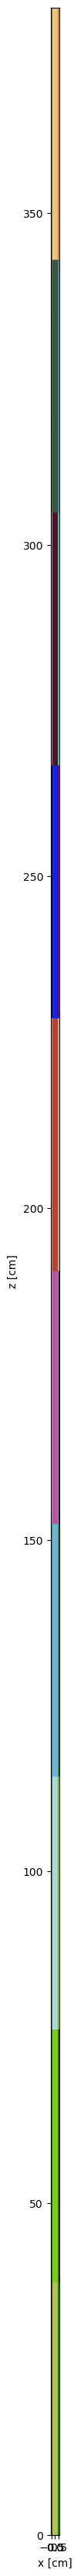

In [19]:
root.plot(width=(pitch, height), basis='xz')

In [20]:
geometry = openmc.Geometry(root)
geometry.export_to_xml()

## Tallies

In [21]:
cell_filter = openmc.CellFilter(fuel_cells)
fission_tally = openmc.Tally()
fission_tally.scores = ['kappa-fission']
fission_tally.filters = [cell_filter]

In [22]:
tallies = openmc.Tallies([fission_tally])
tallies.export_to_xml()

## Starting Source and Settings

In [23]:
settings = openmc.Settings()

# Create an initial uniform spatial source distribution over fissionable zones
lower_left = (-pitch/2, -pitch/2, 0.0)
upper_right = (pitch/2, pitch/2, height)
uniform_dist = openmc.stats.Box(lower_left, upper_right, only_fissionable = True)

settings.source = openmc.source.IndependentSource(space=uniform_dist)

In [24]:
settings.batches = 50
settings.inactive = 10
settings.particles = 2000

settings.temperature = {'default' : T_inlet}
settings.temperature['method'] = 'interpolation'
settings.temperature['multipole'] = True
settings.temperature['range'] = (294., 3000.)

In [25]:
settings.export_to_xml()

# Running OpenMC: All-at-Once

In [26]:
openmc.run()

[v5:230814] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
 

# Running OpenMC: Step-By-Step

In [27]:
import openmc.lib

In [28]:
# Initialization
openmc.lib.init()

[v5:226315] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [29]:
# Clearing tally data
openmc.lib.reset()

In [30]:
# Running OpenMC
openmc.lib.run()

 Maximum neutron transport energy: 20000000 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.28486
        2/1    1.27126
        3/1    1.20896
        4/1    1.23491
        5/1    1.26180
        6/1    1.28363
        7/1    1.27790
        8/1    1.26083
        9/1    1.27125
       10/1    1.24073
       11/1    1.25638
       12/1    1.28026    1.26832 +/- 0.01194
       13/1    1.26502    1.26722 +/- 0.00698
       14/1    1.31833    1.28000 +/- 0.01370
       15/1    1.28283    1.28056 +/- 0.01063
       16/1    1.28810    1.28182 +/- 0.00877
       17/1    1.22964    1.27437 +/- 0.01051
       18/1    1.30442    1.27812 +/- 0.00985
       19/1    1.29170    1.27963 +/- 0.00881
       20/1    1.27066    1.27873 +/- 0.00793
       21/1    1.29701    1.28039 +/- 0.00737
       22/1    1.27852    1.2802

In [31]:
# Finalize OpenMC
openmc.lib.finalize()

# Running OpenMC: Multiphysics Iteration

In [33]:
n_iterations = 3

In [34]:
q_iterations = []
fluid_temp_iterations = []
solid_temp_iterations = []
fluid_density_iterations = []

In [35]:
# due to Picard being low order, makes this more stable
alpha = 0.5

In [36]:
# point location lookup
cell_centers = np.linspace(H/2, height - H/2, N)

x_fuel = 0
x_clad = Rf + 0.0001
x_fluid = R + 0.0001

with openmc.lib.run_in_memory():
      for i in range(n_iterations):
          openmc.lib.reset()
          openmc.lib.run()

          # DO STUFF - such as multiphysics!

In [39]:
settings.particles = 10000
settings.export_to_xml()

with openmc.lib.run_in_memory():
    for i in range(n_iterations):
        openmc.lib.reset()

        openmc.lib.run(output=False)

        # ---- Multiphysics feedback part ---- #

        # get the total kappa fission computed by OpenMC over the entire domain
        total_kappa_fission = openmc.lib.tallies[1].mean.sum()

        # power (W) in each layer of the solid
        q = np.zeros(N)

        for j in range(N):
            q[j] = openmc.lib.tallies[1].mean[j] / total_kappa_fission

            # to get in units of W, multiply by the total power
            q[j] *= power

            # for greater than the first iteration, relax
            if (i > 0):
                q[j] = (1.0 - alpha) * q_iterations[i - 1][j] + alpha * q[j]

        # compute the fluid temps, fluid densities, and solid temps
        fluid_temps = th_backend.fluid_temperature(q, T_inlet, N)
        fluid_densities = th_backend.fluid_density(fluid_temps, N)
        solid_temps = th_backend.solid_temperature(q, fluid_temps, N, R, Rf, H)

        print("\nIteration {:3n}".format(i))
        for j in range(N):
            print("Layer {:3n}:  Percent power: {:5.1f}  Fluid T: {:7.1f}  Solid T: {:7.1f}  Fluid density: {:5.2f}".format(j, q[j] / power * 100, fluid_temps[j], solid_temps[j], fluid_densities[j]))

            z = cell_centers[j]

            # solid temperature
            cell_s, instance_s = openmc.lib.find_cell((x_fuel, 0, z))
            cell_s.set_temperature(solid_temps[j], instance_s)

            # clad temperature (just set to fluid temperature)
            cell_c, instance_c = openmc.lib.find_cell((x_clad, 0, z))
            cell_c.set_temperature(fluid_temps[j], instance_c)

            # get a point in the fluid phase to find the fluid cell
            cell_f, instance_f = openmc.lib.find_cell((x_fluid, 0, z))
            cell_f.set_temperature(fluid_temps[j], instance_f)

            # find the material in the fluid cell
            material = openmc.lib.find_material((x_fluid, 0, z))
            material.set_density(fluid_densities[j], 'g/cc')

        # save all of the fields computed from this iteration for plotting later
        q_iterations.append(q)
        fluid_temp_iterations.append(fluid_temps)
        fluid_density_iterations.append(fluid_densities)
        solid_temp_iterations.append(solid_temps)


Iteration   0
Layer   0:  Percent power:   4.0  Fluid T:   574.0  Solid T:   687.0  Fluid density:  0.72
Layer   1:  Percent power:  10.1  Fluid T:   577.3  Solid T:   861.7  Fluid density:  0.71
Layer   2:  Percent power:  12.7  Fluid T:   582.8  Solid T:   941.0  Fluid density:  0.70
Layer   3:  Percent power:  12.6  Fluid T:   588.8  Solid T:   945.2  Fluid density:  0.69
Layer   4:  Percent power:  12.7  Fluid T:   594.9  Solid T:   954.4  Fluid density:  0.67
Layer   5:  Percent power:  12.7  Fluid T:   601.0  Solid T:   960.5  Fluid density:  0.66
Layer   6:  Percent power:  12.1  Fluid T:   606.9  Solid T:   947.3  Fluid density:  0.64
Layer   7:  Percent power:  10.5  Fluid T:   612.3  Solid T:   909.8  Fluid density:  0.62
Layer   8:  Percent power:   8.6  Fluid T:   616.9  Solid T:   860.3  Fluid density:  0.61
Layer   9:  Percent power:   3.9  Fluid T:   619.9  Solid T:   731.3  Fluid density:  0.60


/tmp/ipykernel_226315/2139344585.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  q[j] = openmc.lib.tallies[1].mean[j] / total_kappa_fission



Iteration   1
Layer   0:  Percent power:   4.6  Fluid T:   574.1  Solid T:   705.4  Fluid density:  0.72
Layer   1:  Percent power:  10.5  Fluid T:   577.7  Solid T:   874.9  Fluid density:  0.71
Layer   2:  Percent power:  12.9  Fluid T:   583.3  Solid T:   946.9  Fluid density:  0.70
Layer   3:  Percent power:  13.6  Fluid T:   589.7  Solid T:   973.3  Fluid density:  0.69
Layer   4:  Percent power:  12.7  Fluid T:   595.9  Solid T:   954.1  Fluid density:  0.67
Layer   5:  Percent power:  12.7  Fluid T:   602.0  Solid T:   960.5  Fluid density:  0.66
Layer   6:  Percent power:  11.2  Fluid T:   607.7  Solid T:   924.8  Fluid density:  0.64
Layer   7:  Percent power:  10.1  Fluid T:   612.8  Solid T:   898.4  Fluid density:  0.62
Layer   8:  Percent power:   8.2  Fluid T:   617.2  Solid T:   848.3  Fluid density:  0.61
Layer   9:  Percent power:   3.5  Fluid T:   620.0  Solid T:   717.8  Fluid density:  0.60

Iteration   2
Layer   0:  Percent power:   4.8  Fluid T:   574.1  Solid T:

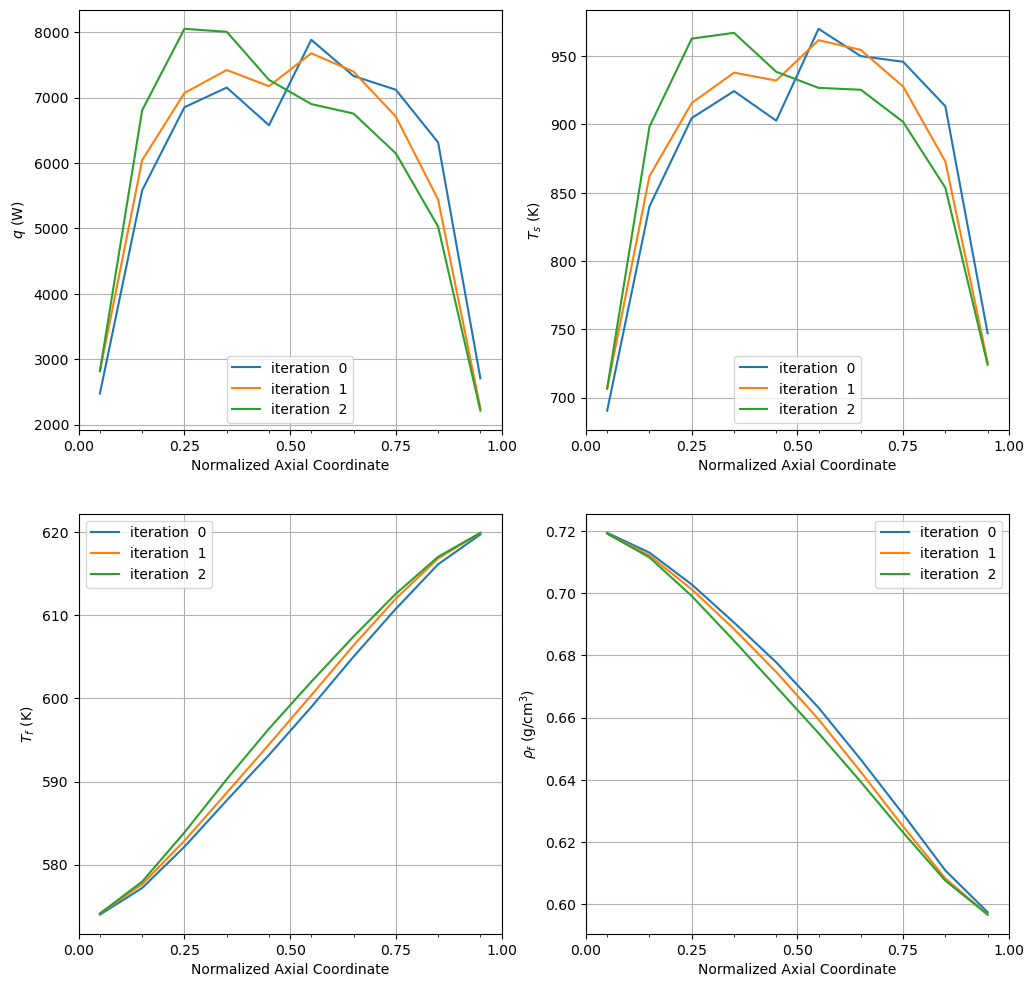

In [40]:
import matplotlib
import matplotlib.pyplot as plt

normalized_cell_centers = np.array([c / height for c in cell_centers])
font = {'size' : 10}
matplotlib.rc('font', **font)

fig, axs = plt.subplots(2, 2, figsize=(12,12))

for i in range(n_iterations):
    axs[0, 0].plot(normalized_cell_centers, q_iterations[i], label = 'iteration {:2n}'.format(i))
    axs[0, 0].set_ylabel('$q$ (W)')

    axs[0, 1].plot(normalized_cell_centers, solid_temp_iterations[i], label = 'iteration {:2n}'.format(i))
    axs[0, 1].set_ylabel('$T_s$ (K)')

    axs[1, 0].plot(normalized_cell_centers, fluid_temp_iterations[i], label = 'iteration {:2n}'.format(i))
    axs[1, 0].set_ylabel('$T_f$ (K)')

    axs[1, 1].plot(normalized_cell_centers, fluid_density_iterations[i], label = 'iteration {:2n}'.format(i))
    axs[1, 1].set_ylabel('$\\rho_f$ (g/cm$^3$)')

for ax in axs.flat:
    ax.set(xlabel = 'Normalized Axial Coordinate')
    ticks = np.arange(H / height / 2.0, 1.0, H / height)
    ax.set_xticks([0.0, 0.25, 0.5, 0.75, 1.0])
    ax.set_xticks(ticks, minor = True)
    ax.legend()
    ax.grid()